In [1]:
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dataset_v2/train.csv')
df_val = pd.read_csv('dataset_v2/validation.csv')
df_test = pd.read_csv('dataset_v2/test.csv')

,text,title,description,keywords,theme,url,authors,date,kmonitor_description,kmonitor_title,kmonitor_tags,institutes,people
0,Mozgalmasan telnek Eva Rezesová utolsó napjai ...,Így telnek Rezesova utolsó napjai a börtönben,Mozgalmasan telnek Eva Rezesová utolsó napjai ...,NaN,0,http://www.blikk.hu/aktualis/belfold/rabtarsai...,NaN,2018-08-27 03:09:12+02:00,NaN,NaN,NaN,NaN,NaN
1,A Föld légkörébe visszatérő ballisztikus rakét...,Kinéztek a repülő ablakán és egy észak-koreai ...,Kinéztek a repülő ablakán és egy észak-koreai ...,"ballisztikus rakéta,észak-korea,fegyverkezés,k...",0,https://index.hu/kulfold/2017/12/04/kineztek_a...,Dezső András,2017-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN
2,A 8. rendű vádlott egy szerelmi kaland miatt b...,Belföld: Szerelmi szál a Zuschlag-ügyben,A 8. rendű vádlott egy szerelmi kaland miatt b...,"2008-12-05,Zuschlag-ügy",1,https://nol.hu/belfold/szerelmi_szal_a_zuschla...,NaN,2008-12-05 13:18:00+01:00,A 8. rendű vádlott egy szerelmi kaland miatt b...,Szerelmi szál a Zuschlag-ügyben,"Zuschlag-ügy,csalás,magánokirat-hamisítás",NaN,"Kisbaranyi László,Kubatov Iván,Szente Zsolt (ü..."
3,A Rendvédelmi Szervek Védelmi Szolgálata (RSZV...,A belső elhárítás tudott a békési rendőrügyekről,A Rendvédelmi Szervek Védelmi Szolgálata (RSZV...,NaN,1,https://www.origo.hu/itthon/19991006abelso.html,Magyar Hírlap,NaN,A Rendvédelmi Szervek Védelmi Szolgálata (RSZV...,A belső elhárítás tudott a békési rendőrügyekről,"Olajügyek,Olajügyek,bűnpártolás,Békés megye",Rendőrség,Gál László
4,A B Build & Trade Kft. építheti fel az új spor...,Új sportcsarnok és három focipálya épül Pécset...,A B Build & Trade Kft. építheti fel az új spor...,"b build kft.,foci,közbeszerzés,pécs,pécsi vasu...",1,https://orszagszerte.atlatszo.hu/uj-sportcsarn...,"Zsilák Szilvia,Kármán Irén,Katus Eszter,Huszka...",2021-04-28 10:25:00+00:00,NaN,Új sportcsarnok és három focipálya épül Pécset...,"közbeszerzés,sport,Baranya megye,Pécs",B Build&Trade Kft.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49601,Többnyire emelkedtek a vezető ázsiai tőzsdemut...,"Gazdaság: Erősödés Ázsiában, a Wall Street csö...",Többnyire emelkedtek a vezető ázsiai tőzsdemut...,NaN,0,https://hvg.hu/gazdasag/20110322_erosodes_azsi...,Hvg Kiadó Zrt.,2011-03-22 08:32:00+01:00,NaN,NaN,NaN,NaN,NaN
49602,Borsot törnek nagy riválisaik orra alá azok a ...,Rés a piacon,Borsot törnek nagy riválisaik orra alá azok a ...,vállalkozás print,0,https://24.hu/fn/uzleti-tippek/2008/06/03/res_...,NaN,2008-06-03 00:00:00,NaN,NaN,NaN,NaN,NaN
49603,A Semmelweis Egyetem szenátusa visszavonta Sch...,A szenátus visszavonta a Schmitt-doktorit,A szenátus visszavonta a Schmitt-doktorit - A ...,"schmitt pál,plágium,tulassay tivadar,semmelwei...",1,http://index.hu/belfold/2012/03/29/elvettek_sc...,NaN,2012-03-29 00:00:00,A Semmelweis Egyetem szenátusa visszavonta Sch...,A szenátus visszavonta a Schmitt-doktorit,"ítélet/döntés,oktatás,plágium,sport,tudomány",Semmelweis Egyetem (SE/SOTE),Schmitt Pál
49604,A Kúrián is megnyerte a tao-támogatások nyilvá...,"Kiderült, hogy közpénz a tao, de a minisztériu...","Most, hogy ki kellene adni, az NGM-nél hirtele...","ngm,tao-támogatás.,transparency international",1,https://g7.24.hu/allam/20171025/kiderult-hogy-...,"Jandó Zoltán,Hajdu Miklós,Bucsky Péter,Stubnya...",2017-10-25 00:00:00,A Kúrián is megnyerte a tao-támogatások nyilvá...,"Kiderült, hogy közpénz a tao, de a minisztériu...","TAO-pénzek,adatigénylés,átláthatóság,ítélet/dö...","Emberi Erőforrások Minisztériuma (EMMI),Felcsú...",Mészáros Lőrinc


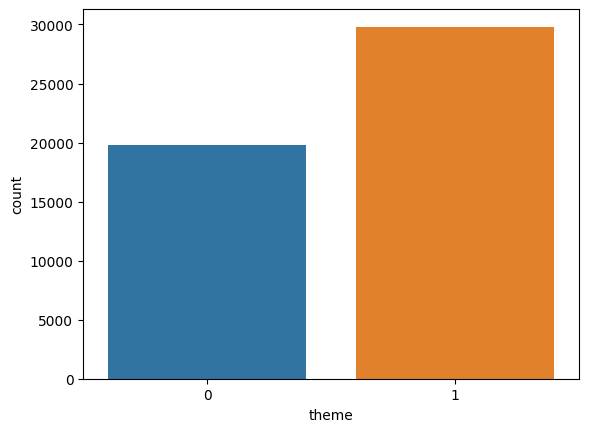

In [3]:
ax = sns.countplot(x="theme", data=df)

In [4]:
def clean_text(text):
    if isinstance(text, float):
        return ''
    if isinstance(text, pd.Series):
        text = [t for t in text if isinstance(t, str)]
        text = ','.join(text)
    text = text.lower()
    text = text.replace('  ', ' ')

    punctuations = '@#!?+&*[]%.:/\\();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p,'')
    text = text.replace(' ', '_')
    text = text.replace('-', '_')
    text = text.replace('__', '_')
    text = text.replace(',', ' ')

    return text

In [5]:
df['keys'] = df.apply(lambda x: clean_text(x['keywords']), axis=1)
df_val['keys'] = df_val.apply(lambda x: clean_text(x['keywords']), axis=1)
df_test['keys'] = df_test.apply(lambda x: clean_text(x['keywords']), axis=1)

df['theme'] = df['theme'].apply(lambda x: x if x == 1 else 0)
df.head()['keys']

,text,title,description,keywords,theme,url,authors,date,kmonitor_description,kmonitor_title,kmonitor_tags,institutes,people,keys
0,Mozgalmasan telnek Eva Rezesová utolsó napjai ...,Így telnek Rezesova utolsó napjai a börtönben,Mozgalmasan telnek Eva Rezesová utolsó napjai ...,NaN,0,http://www.blikk.hu/aktualis/belfold/rabtarsai...,NaN,2018-08-27 03:09:12+02:00,NaN,NaN,NaN,NaN,NaN,
1,A Föld légkörébe visszatérő ballisztikus rakét...,Kinéztek a repülő ablakán és egy észak-koreai ...,Kinéztek a repülő ablakán és egy észak-koreai ...,"ballisztikus rakéta,észak-korea,fegyverkezés,k...",0,https://index.hu/kulfold/2017/12/04/kineztek_a...,Dezső András,2017-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,ballisztikus_rakéta észak_korea fegyverkezés k...
2,A 8. rendű vádlott egy szerelmi kaland miatt b...,Belföld: Szerelmi szál a Zuschlag-ügyben,A 8. rendű vádlott egy szerelmi kaland miatt b...,"2008-12-05,Zuschlag-ügy",1,https://nol.hu/belfold/szerelmi_szal_a_zuschla...,NaN,2008-12-05 13:18:00+01:00,A 8. rendű vádlott egy szerelmi kaland miatt b...,Szerelmi szál a Zuschlag-ügyben,"Zuschlag-ügy,csalás,magánokirat-hamisítás",NaN,"Kisbaranyi László,Kubatov Iván,Szente Zsolt (ü...",2008_12_05 zuschlag_ügy
3,A Rendvédelmi Szervek Védelmi Szolgálata (RSZV...,A belső elhárítás tudott a békési rendőrügyekről,A Rendvédelmi Szervek Védelmi Szolgálata (RSZV...,NaN,1,https://www.origo.hu/itthon/19991006abelso.html,Magyar Hírlap,NaN,A Rendvédelmi Szervek Védelmi Szolgálata (RSZV...,A belső elhárítás tudott a békési rendőrügyekről,"Olajügyek,Olajügyek,bűnpártolás,Békés megye",Rendőrség,Gál László,
4,A B Build & Trade Kft. építheti fel az új spor...,Új sportcsarnok és három focipálya épül Pécset...,A B Build & Trade Kft. építheti fel az új spor...,"b build kft.,foci,közbeszerzés,pécs,pécsi vasu...",1,https://orszagszerte.atlatszo.hu/uj-sportcsarn...,"Zsilák Szilvia,Kármán Irén,Katus Eszter,Huszka...",2021-04-28 10:25:00+00:00,NaN,Új sportcsarnok és három focipálya épül Pécset...,"közbeszerzés,sport,Baranya megye,Pécs",B Build&Trade Kft.,NaN,b_build_kft foci közbeszerzés pécs pécsi_vasut...


In [7]:
common = list(df['keys'].value_counts().to_frame()[:50][df['keys'].value_counts().to_frame()[:50].index.str.len() > 50].index.values)
common

['cikk képriport képek kép anyag elemzés politika külpolitika magyar nemzet magyar_nemzet mno magyar_nemzet_online hír archívum újság publicisztika interjú hírek időjárás dokumentum idézet fórum gazdaság külföld vezércikk krónika sport álhír szavazás kultúra sport oktatás pártok költségvetés egészségügy agrárium energia egyházak pedagógusok önkormányzat régiók minisztériumok képviselők határon_túli_magyarság miniszterelnök baleset ellenzék vita galéria',
 'mindeközben percről_percre világmindenség univerzum',
 'inforádió magyarország audió belföld belföldi belföldi_hírek budapest bulvár életmód élő_adás feed friss_hírek gazdaság gazdasági_hírek hír hírek hírlevél info_budapest info_hu info_radio info_rádió inforádió infórádió internet_radio képek kultúra kultúrális külföld külföldi legfrissebb_hírek magazin magyarország műsor news newsfeed podcast podcast_rss podcasting radio rádió rendőrségi_hírek rss sport sport_hírek sports színes_bulvár xml',
 'hírek gazdaság vállalatvezetés minősé

In [8]:
df['keys'] = df['keys'].apply(lambda x: x if x not in common else '')

In [9]:
df = df[df['keys'] != '']

In [10]:
df

,text,title,description,keywords,theme,url,authors,date,kmonitor_description,kmonitor_title,kmonitor_tags,institutes,people,keys
1,A Föld légkörébe visszatérő ballisztikus rakét...,Kinéztek a repülő ablakán és egy észak-koreai ...,Kinéztek a repülő ablakán és egy észak-koreai ...,"ballisztikus rakéta,észak-korea,fegyverkezés,k...",0,https://index.hu/kulfold/2017/12/04/kineztek_a...,Dezső András,2017-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,ballisztikus_rakéta észak_korea fegyverkezés k...
2,A 8. rendű vádlott egy szerelmi kaland miatt b...,Belföld: Szerelmi szál a Zuschlag-ügyben,A 8. rendű vádlott egy szerelmi kaland miatt b...,"2008-12-05,Zuschlag-ügy",1,https://nol.hu/belfold/szerelmi_szal_a_zuschla...,NaN,2008-12-05 13:18:00+01:00,A 8. rendű vádlott egy szerelmi kaland miatt b...,Szerelmi szál a Zuschlag-ügyben,"Zuschlag-ügy,csalás,magánokirat-hamisítás",NaN,"Kisbaranyi László,Kubatov Iván,Szente Zsolt (ü...",2008_12_05 zuschlag_ügy
4,A B Build & Trade Kft. építheti fel az új spor...,Új sportcsarnok és három focipálya épül Pécset...,A B Build & Trade Kft. építheti fel az új spor...,"b build kft.,foci,közbeszerzés,pécs,pécsi vasu...",1,https://orszagszerte.atlatszo.hu/uj-sportcsarn...,"Zsilák Szilvia,Kármán Irén,Katus Eszter,Huszka...",2021-04-28 10:25:00+00:00,NaN,Új sportcsarnok és három focipálya épül Pécset...,"közbeszerzés,sport,Baranya megye,Pécs",B Build&Trade Kft.,NaN,b_build_kft foci közbeszerzés pécs pécsi_vasut...
5,Teljes modellváltást hajt végre Magyarországon...,Megváltoztatja a NER megjelenése a magyar Mekit,Teljes modellváltást hajt végre Magyarországon...,"Vállalatok,McDonald's",0,https://mfor.hu/cikkek/vallalatok/megvaltoztat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vállalatok mcdonalds
7,A három magyar labdarúgót is foglalkoztató Liv...,Két magyarral kapott ki a Livingston,Két magyarral kapott ki a Livingston,sport,0,http://index.hu/sport/futball/hirek/2005/01/29...,NaN,2005-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN,sport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49600,A szabadtéri rendezvények és kiadványok készít...,Zuschlag-per: kampányokra ment a pályázati pénz,Zuschlag-per: kampányokra ment a pályázati pén...,"belföld,zuschlag",1,https://index.hu/belfold/lds3060,Index Mti,2008-11-05 13:25:00+01:00,A szabadtéri rendezvények és kiadványok készít...,Zuschlag-per: kampányokra ment a pályázati pénz,"Zuschlag-ügy,pártfinanszírozás,rendezvényszerv...","MSZP,Táncsics Mihály Alapítvány","Baráth Etele,Csiha Judit,Katus Ferenc,Lados Is...",belföld zuschlag
49602,Borsot törnek nagy riválisaik orra alá azok a ...,Rés a piacon,Borsot törnek nagy riválisaik orra alá azok a ...,vállalkozás print,0,https://24.hu/fn/uzleti-tippek/2008/06/03/res_...,NaN,2008-06-03 00:00:00,NaN,NaN,NaN,NaN,NaN,vállalkozás_print
49603,A Semmelweis Egyetem szenátusa visszavonta Sch...,A szenátus visszavonta a Schmitt-doktorit,A szenátus visszavonta a Schmitt-doktorit - A ...,"schmitt pál,plágium,tulassay tivadar,semmelwei...",1,http://index.hu/belfold/2012/03/29/elvettek_sc...,NaN,2012-03-29 00:00:00,A Semmelweis Egyetem szenátusa visszavonta Sch...,A szenátus visszavonta a Schmitt-doktorit,"ítélet/döntés,oktatás,plágium,sport,tudomány",Semmelweis Egyetem (SE/SOTE),Schmitt Pál,schmitt_pál plágium tulassay_tivadar semmelwei...
49604,A Kúrián is megnyerte a tao-támogatások nyilvá...,"Kiderült, hogy közpénz a tao, de a minisztériu...","Most, hogy ki kellene adni, az NGM-nél hirtele...","ngm,tao-támogatás.,transparency international",1,https://g7.24.hu/allam/20171025/kiderult-hogy-...,"Jandó Zoltán,Hajdu Miklós,Bucsky Péter,Stubnya...",2017-10-25 00:00:00,A Kúrián is megnyerte a tao-támogatások nyilvá...,"Kiderült, hogy közpénz a tao, de a minisztériu...","TAO-pénzek,adatigénylés,átláthatóság,ítélet/dö...","Emberi Erőforrások Minisztériuma (EMMI),Felcsú...",Mészáros Lőrinc,ngm tao_támogatás transparency_international


In [11]:
X_train = df['keys'].values
X_test = df_test['keys'].values

y_train = df['theme'].values
y_test = df_test['theme'].values

url_train = df['url'].values
url_test = df_test['url'].values
url_train

array(['https://index.hu/kulfold/2017/12/04/kineztek_a_repulo_ablakan_es_egy_eszak-koreai_raketat_lattak',
       'https://nol.hu/belfold/szerelmi_szal_a_zuschlag-ugyben',
       'https://orszagszerte.atlatszo.hu/uj-sportcsarnok-es-harom-focipalya-epul-pecsett-netto-2-milliard-forintert-de-stadiont-is-igernek',
       ...,
       'http://index.hu/belfold/2012/03/29/elvettek_schmitt_doktorijat',
       'https://g7.24.hu/allam/20171025/kiderult-hogy-kozpenz-a-tao-de-a-miniszteriumban-hirtelen-eltuntek-az-iratok',
       'https://nol.hu/belfold/kirugtak_a_bkv_szokesben_levo_informatikai_igazgatojat'],
      dtype=object)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse
import numpy as np
import pandas as pd
import csv

vect = CountVectorizer()
tfidf_train_vectors = vect.fit_transform(X_train)
tfidf_test_vectors = vect.transform(X_test)

classifier = RandomForestClassifier()
classifier.fit(tfidf_train_vectors,y_train)

y_proba = classifier.predict_proba(tfidf_test_vectors)
with open('bow_validation.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for proba, label in zip(y_proba, y_test):
        csvwriter.writerow([proba[0], int(label)])

In [ ]:
total = 0
for i in range(10):
    classifier = RandomForestClassifier(random_state = i)
    classifier.fit(tfidf_train_vectors,y_train)
    
    y_pred = classifier.predict(tfidf_test_vectors)

    total += classification_report(y_test,y_pred, output_dict=True)['accuracy']
    print(classification_report(y_test,y_pred, output_dict=True)['accuracy'])

print(f'Test Accuracy: {total/10: .5f}')